In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv") 
X = df.drop("purchaseValue", axis=1) 
y = df['purchaseValue'] 
from sklearn.dummy import DummyRegressor 
model = DummyRegressor().fit(X,y) 
X_test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv") 
y_pred=model.predict(X_test) 
submission = pd.DataFrame({"id": range(0,X_test.shape[0]), "purchaseValue": y_pred}) 
submission.to_csv('submission.csv',index=False)





In [2]:
 # Install required packages (if needed)
!pip install lightgbm xgboost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend for Kaggle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


# *1. Data Loading*

In [3]:
# Load data with Kaggle paths
print("=== 1. DATA LOADING ===")
train = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
print(f" Train shape: {train.shape}")
print(f" Test shape: {test.shape}")

=== 1. DATA LOADING ===
 Train shape: (116023, 52)
 Test shape: (29006, 51)


In [4]:
train.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


In [5]:
test.describe()

,date,totals.bounces,totalHits,new_visits,pageViews,totals.visits,trafficSource.adwordsClickInfo.page,sessionId,sessionNumber,sessionStart,userId,locationZone,gclIdPresent
count,2.900600e+04,11732.0,29006.000000,20094.0,29003.000000,29006.0,1107.000000,2.900600e+04,29006.000000,2.900600e+04,29006.000000,29006.0,29006.000000
mean,2.016855e+07,1.0,10.659519,1.0,8.470813,1.0,1.015357,1.493320e+09,2.595980,1.493320e+09,61327.854134,8.0,0.038268
std,6.200443e+03,0.0,19.771218,0.0,14.561705,0.0,0.177227,1.532493e+07,9.333323,1.532493e+07,35253.344987,0.0,0.191846
min,2.016080e+07,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.470035e+09,1.000000,1.470035e+09,8.000000,8.0,0.000000
25%,2.016112e+07,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.479931e+09,1.000000,1.479931e+09,31006.500000,8.0,0.000000
50%,2.017041e+07,1.0,2.000000,1.0,2.000000,1.0,1.000000,1.491492e+09,1.000000,1.491492e+09,61430.500000,8.0,0.000000
75%,2.017091e+07,1.0,12.000000,1.0,10.000000,1.0,1.000000,1.505148e+09,2.000000,1.505148e+09,91866.250000,8.0,0.000000
max,2.018043e+07,1.0,500.000000,1.0,466.000000,1.0,5.000000,1.525152e+09,334.000000,1.525152e+09,122268.000000,8.0,1.000000


In [6]:
test.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   device.browserSize                            29006 non-null  object 
 4   device.browserVersion                         29006 non-null  object 
 5   deviceType                                    29006 non-null  object 
 6   device.flashVersion                           29006 non-null  object 
 7   device.isMobile                               29006 non-null  bool   
 8   device.language                               29006 non-null  object 
 9   device.mobileDeviceBranding                   29006 non-null 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

# *Exploratory Data Analysis (EDA)*
In this section, we explore the target variable and inspect the dataset for missing values and distributions.

* Analyze the target column (purchaseValue) to understand its distribution.

* Visualize the skewness and imbalance using a histogram.

* Identify missing values to guide preprocessing decisions.

We also prepare the dataset by handling high-missing columns and filling null values.



 **Target Variable Analysis (purchaseValue)**

In this step, we explore the distribution of the target variable:
* Histogram of raw purchaseValue to identify skewness.
* Log-transformed histogram to reduce skew and improve model performance.
*  Bar plots to compare average purchase values across:
   1. DeviceType    2. TrafficSource.medium


 STARTING KAGGLE PIPELINE WITH VISUALIZATIONS
 TARGET DISTRIBUTION ANALYSIS


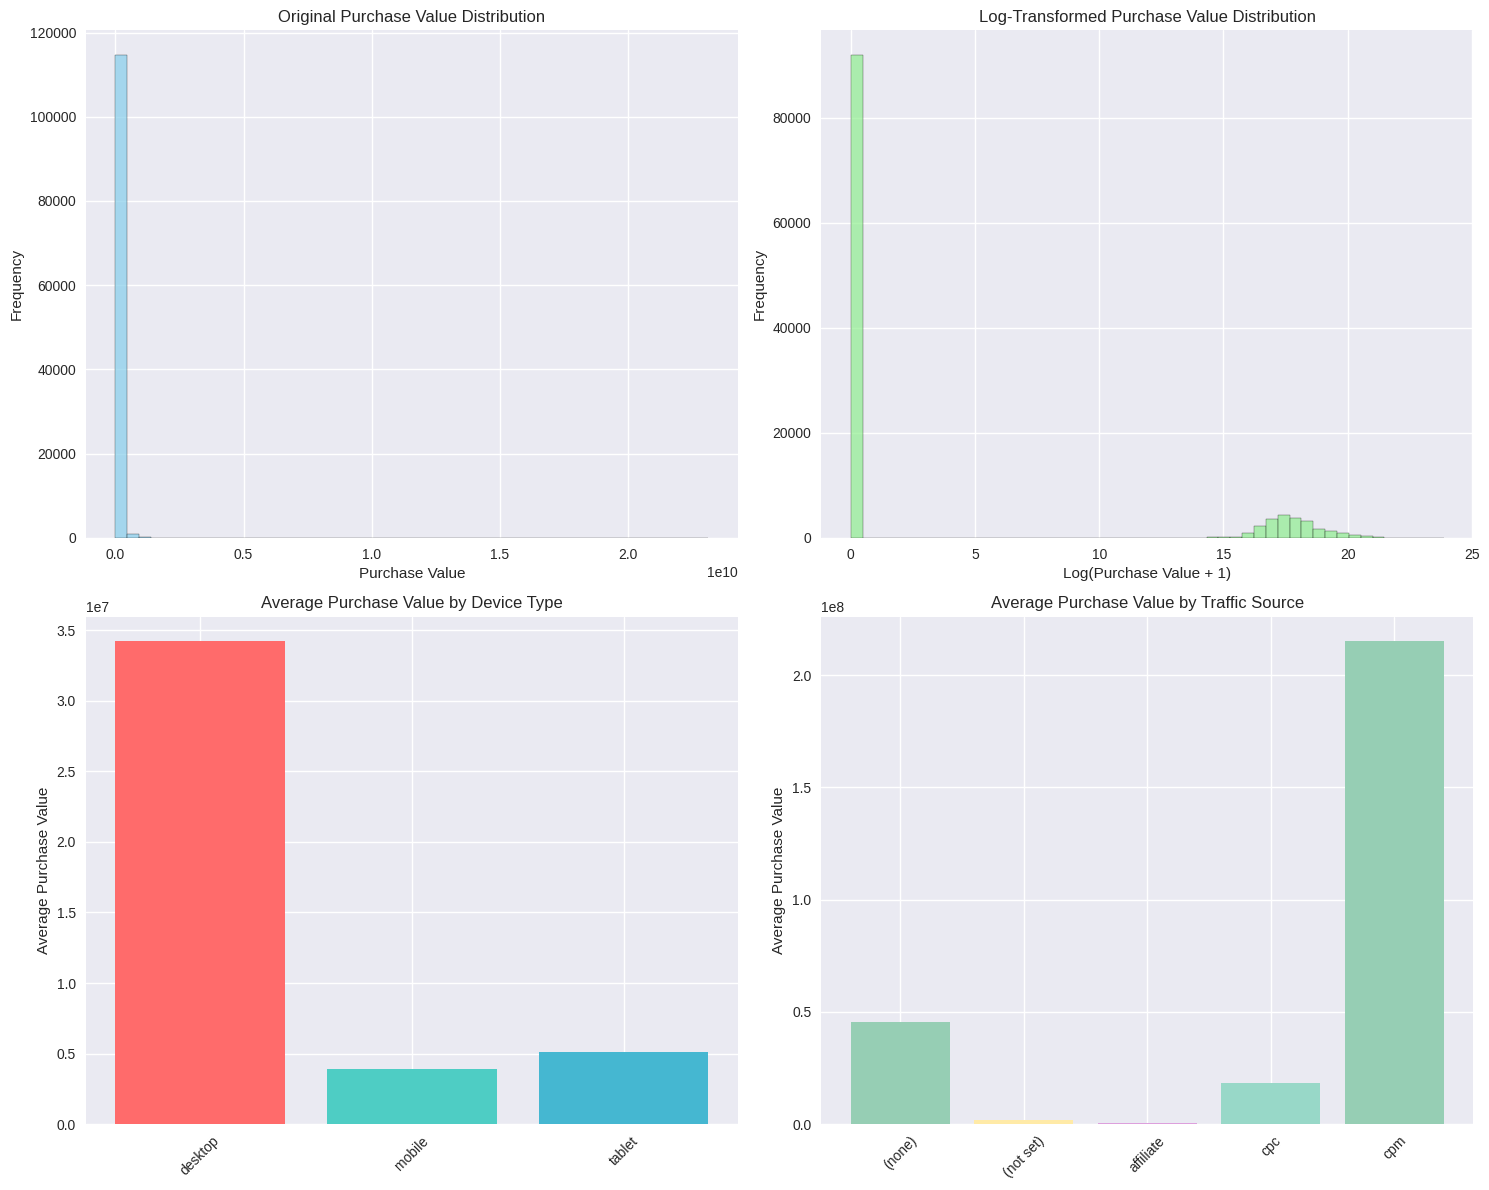

In [8]:


# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" STARTING KAGGLE PIPELINE WITH VISUALIZATIONS")
print("=" * 50)

# Load data
train = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

# 1. Target Distribution Visualization
print(" TARGET DISTRIBUTION ANALYSIS")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original target distribution
axes[0, 0].hist(train['purchaseValue'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Original Purchase Value Distribution')
axes[0, 0].set_xlabel('Purchase Value')
axes[0, 0].set_ylabel('Frequency')

# Log-transformed target distribution
log_values = np.log1p(train['purchaseValue'])
axes[0, 1].hist(log_values, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Log-Transformed Purchase Value Distribution')
axes[0, 1].set_xlabel('Log(Purchase Value + 1)')
axes[0, 1].set_ylabel('Frequency')

# Box plot of target by device type
if 'deviceType' in train.columns:
    device_means = train.groupby('deviceType')['purchaseValue'].mean()
    axes[1, 0].bar(device_means.index, device_means.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1, 0].set_title('Average Purchase Value by Device Type')
    axes[1, 0].set_ylabel('Average Purchase Value')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Box plot of target by traffic source
if 'trafficSource.medium' in train.columns:
    traffic_means = train.groupby('trafficSource.medium')['purchaseValue'].mean().head(5)
    axes[1, 1].bar(traffic_means.index, traffic_means.values, color=['#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8'])
    axes[1, 1].set_title('Average Purchase Value by Traffic Source')
    axes[1, 1].set_ylabel('Average Purchase Value')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
display(plt.gcf())
plt.close()

**train_data.csv — Top columns with missing values:**

In [9]:

#  Column-wise Missing Value Count
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)


missing_df = pd.DataFrame({
    'Column Name': missing_train.index,
    'Missing Values': missing_train.values
})
missing_df['Missing Values'] = missing_df['Missing Values'].apply(lambda x: f"{x:,}")

#  Print Output
print("\n train_data.csv — Top columns with missing values:\n")
if not missing_df.empty:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found.")


 train_data.csv — Top columns with missing values:

                                 Column Name Missing Values
                     trafficSource.adContent        113,060
         trafficSource.adwordsClickInfo.slot        111,742
    trafficSource.adwordsClickInfo.isVideoAd        111,742
trafficSource.adwordsClickInfo.adNetworkType        111,742
         trafficSource.adwordsClickInfo.page        111,742
                  trafficSource.referralPath         73,309
                  trafficSource.isTrueDirect         73,133
                       trafficSource.keyword         71,861
                              totals.bounces         68,875
                                  new_visits         35,505
                                   pageViews              8


**test_data.csv — Top columns with missing values:**

In [10]:
#  Column-wise Missing Value Count
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)


missing_df = pd.DataFrame({
    'Column Name': missing_test.index,
    'Missing Values': missing_test.values
})
missing_df['Missing Values'] = missing_df['Missing Values'].apply(lambda x: f"{x:,}")

#  Print Output
print("test_data.csv — Top columns with missing values:\n")
if not missing_df.empty:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found.")

test_data.csv — Top columns with missing values:

                                 Column Name Missing Values
                     trafficSource.adContent         28,247
trafficSource.adwordsClickInfo.adNetworkType         27,899
    trafficSource.adwordsClickInfo.isVideoAd         27,899
         trafficSource.adwordsClickInfo.page         27,899
         trafficSource.adwordsClickInfo.slot         27,899
                  trafficSource.referralPath         18,395
                  trafficSource.isTrueDirect         18,245
                       trafficSource.keyword         17,962
                              totals.bounces         17,274
                                  new_visits          8,912
                                   pageViews              3


In [11]:

print("\n EXPLORATORY DATA ANALYSIS ")
print(f"Target statistics:")
print(train['purchaseValue'].describe())

#  target visualization
plt.figure(figsize=(8,4))
sns.histplot(train['purchaseValue'], bins=50, kde=True)
plt.title('Target Distribution (purchaseValue)')
plt.tight_layout()
plt.savefig('/kaggle/working/eda_target_dist.png')
plt.close()


# Missing data analysis
print(f"\nMissing data analysis:")
missing_train = train.isnull().sum().sort_values(ascending=False).head(10)
print(missing_train)

# Data preprocessing


# Drop high missing columns
missing_train = train.isnull().mean() * 100
missing_test = test.isnull().mean() * 100
cols_to_drop = set(missing_train[missing_train > 90].index).union(
    missing_test[missing_test > 90].index
)
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)


# Fill missing values
train = train.fillna(0)
test = test.fillna(0)

# Check missing values after handling
total_missing_after = train.isnull().sum().sum() + test.isnull().sum().sum()
print(f"\nMissing values remaining after handling: {total_missing_after}")


 EXPLORATORY DATA ANALYSIS 
Target statistics:
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64

Missing data analysis:
trafficSource.adContent                         113060
trafficSource.adwordsClickInfo.isVideoAd        111742
trafficSource.adwordsClickInfo.page             111742
trafficSource.adwordsClickInfo.adNetworkType    111742
trafficSource.adwordsClickInfo.slot             111742
trafficSource.referralPath                       73309
trafficSource.isTrueDirect                       73133
trafficSource.keyword                            71861
totals.bounces                                   68875
new_visits                                       35505
dtype: int64

Missing values remaining after handling: 0


# *Missing Data Visualization*
In this step, we analyze missing values in both the training and test datasets to better understand the quality of the data and identify problematic features.

 **Heatmap of Missing Values**
* Visualize missing data patterns using a heatmap.
* Helps identify if missingness is random or correlated with certain samples or features.

**Top 15 Features with Most Missing Values**

* Bar plots showing the top 15 features with the highest percentage of missing values in both training and test sets.
* This analysis helps guide decisions for dropping or imputing columns.

 MISSING DATA ANALYSIS 


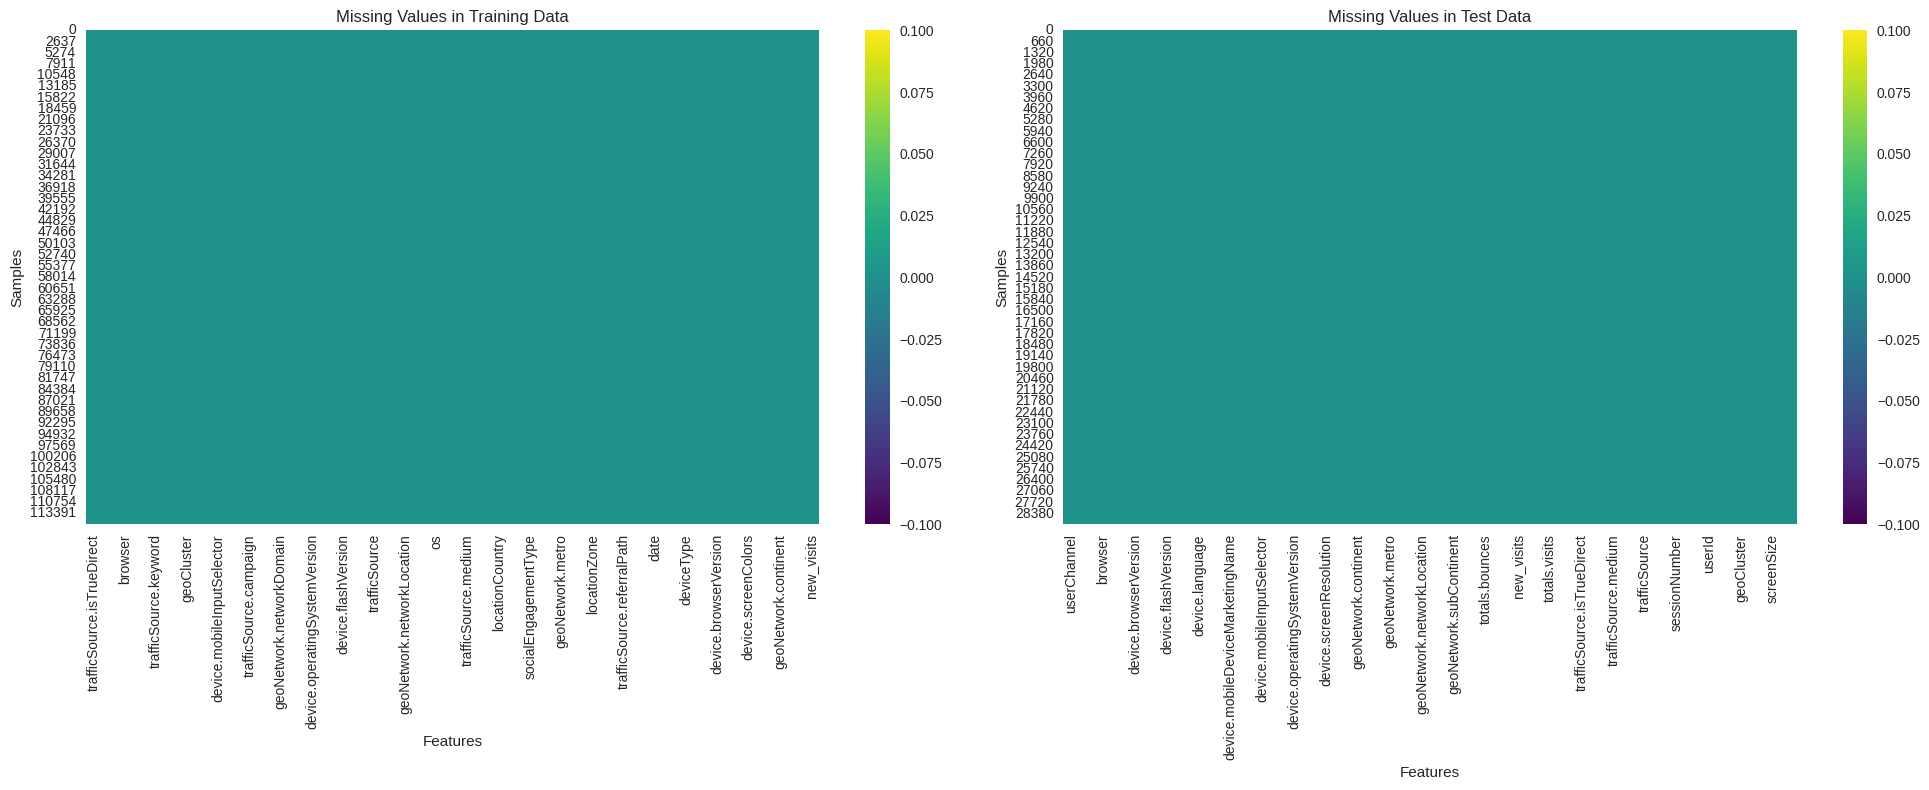

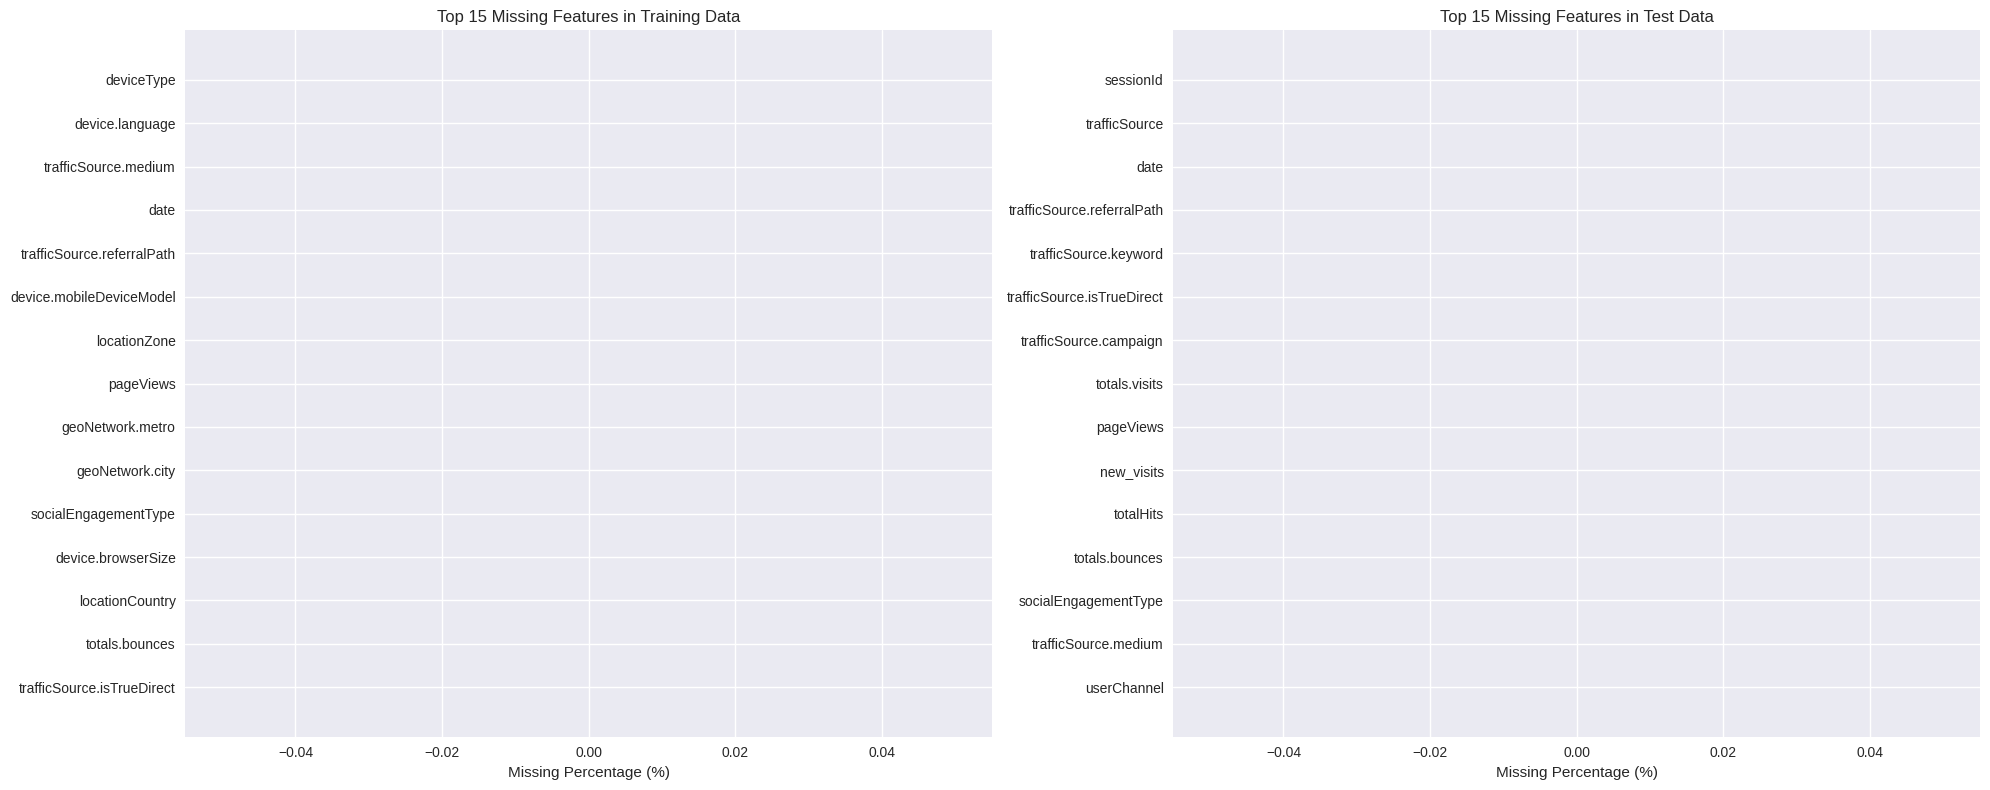

In [12]:
#  Missing Data Visualization
print(" MISSING DATA ANALYSIS ")

# Missing data heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Train missing data
train_missing = train.isnull()
sns.heatmap(train_missing, cbar=True, ax=axes[0], cmap='viridis')
axes[0].set_title('Missing Values in Training Data')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Samples')

# Test missing data
test_missing = test.isnull()
sns.heatmap(test_missing, cbar=True, ax=axes[1], cmap='viridis')
axes[1].set_title('Missing Values in Test Data')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Samples')

plt.tight_layout()
plt.show()
display(plt.gcf())
plt.close()

# Missing data percentage bar plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Top 15 missing features in train
missing_train_pct = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False).head(15)
axes[0].barh(range(len(missing_train_pct)), missing_train_pct.values, color='#FF6B6B')
axes[0].set_yticks(range(len(missing_train_pct)))
axes[0].set_yticklabels(missing_train_pct.index)
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Top 15 Missing Features in Training Data')

# Top 15 missing features in test
missing_test_pct = (test.isnull().sum() / len(test) * 100).sort_values(ascending=False).head(15)
axes[1].barh(range(len(missing_test_pct)), missing_test_pct.values, color='#4ECDC4')
axes[1].set_yticks(range(len(missing_test_pct)))
axes[1].set_yticklabels(missing_test_pct.index)
axes[1].set_xlabel('Missing Percentage (%)')
axes[1].set_title('Top 15 Missing Features in Test Data')

plt.tight_layout()
plt.show()
display(plt.gcf())
plt.close()

# *Feature Engineering*
To enhance the model’s predictive power, we create domain-relevant features based on user behavior, session patterns, and temporal trends.

**User-Based Features**

* Aggregate statistics like average purchase, total hits, and total page views per userId.
* Helps capture overall user activity and spending behavior.

**Session-Based Features**

* Aggregate pageViews and totalHits for each sessionId.
* Useful to measure individual session intensity.

**Engagement Metrics**

* pages_per_hit: Indicates how many pages were viewed per interaction.
* engagement_score: Product of page views and total hits.
* session_efficiency: Normalized engagement over sessions.

**Time-Based Features**  

* Extract hour of day, day of week, and flag for weekend or business hours based on sessionStart timestamp.
* Useful for capturing time-dependent behavior patterns.

**Device & Source Features**

* Encode device types (e.g., mobile, desktop), traffic sources (organic, direct), browsers, and operating systems using custom mappings.
* These scores help reflect engagement likelihood or trust level from different platforms.

**Interaction Features**

* mobile_engagement: How mobile users behave differently.
* weekend_engagement: Engagement levels during weekends.

In [13]:
# feature engineering
print("\nFEATURE ENGINEERING ")

# User-based features
user_stats = train.groupby('userId').agg({
    'purchaseValue': ['mean', 'sum', 'count', 'std'],
    'pageViews': ['mean', 'sum'],
    'totalHits': ['mean', 'sum']
}).reset_index()

user_stats.columns = [
    'userId', 'userAvgPurchase', 'userTotalPurchase', 'userSessions', 'userPurchaseStd',
    'userAvgPageViews', 'userTotalPageViews', 'userAvgHits', 'userTotalHits'
]

train = train.merge(user_stats, on='userId', how='left')
test = test.merge(user_stats, on='userId', how='left')

# Fill NaN values
for col in user_stats.columns:
    if col != 'userId':
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

# Session-based features
session_stats = train.groupby('sessionId').agg({
    'pageViews': 'sum',
    'totalHits': 'sum'
}).reset_index()
session_stats.columns = ['sessionId', 'sessionTotalPageViews', 'sessionTotalHits']

train = train.merge(session_stats, on='sessionId', how='left')
test = test.merge(session_stats, on='sessionId', how='left')

for col in ['sessionTotalPageViews', 'sessionTotalHits']:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

# Engagement features
train['pages_per_hit'] = train['pageViews'] / (train['totalHits'] + 1)
test['pages_per_hit'] = test['pageViews'] / (test['totalHits'] + 1)

train['engagement_score'] = train['pageViews'] * train['totalHits']
test['engagement_score'] = test['pageViews'] * test['totalHits']

train['session_efficiency'] = train['pageViews'] / (train['sessionNumber'] + 1)
test['session_efficiency'] = test['pageViews'] / (test['sessionNumber'] + 1)

# Time-based features
train['session_hour'] = pd.to_datetime(train['sessionStart'], unit='s').dt.hour
test['session_hour'] = pd.to_datetime(test['sessionStart'], unit='s').dt.hour

train['session_dayofweek'] = pd.to_datetime(train['sessionStart'], unit='s').dt.dayofweek
test['session_dayofweek'] = pd.to_datetime(test['sessionStart'], unit='s').dt.dayofweek

train['is_weekend'] = train['session_dayofweek'].isin([5, 6]).astype(int)
test['is_weekend'] = test['session_dayofweek'].isin([5, 6]).astype(int)

train['is_business_hours'] = ((train['session_hour'] >= 9) & (train['session_hour'] <= 17)).astype(int)
test['is_business_hours'] = ((test['session_hour'] >= 9) & (test['session_hour'] <= 17)).astype(int)

# Device features
device_encoding = {'desktop': 1, 'mobile': 0.5, 'tablet': 0.8}
train['device_score'] = train['deviceType'].map(device_encoding).fillna(0.5)
test['device_score'] = test['deviceType'].map(device_encoding).fillna(0.5)

# Traffic source features
traffic_encoding = {'organic': 0.8, 'cpc': 1.0, 'referral': 0.6, 'direct': 0.9}
train['traffic_score'] = train['trafficSource.medium'].map(traffic_encoding).fillna(0.7)
test['traffic_score'] = test['trafficSource.medium'].map(traffic_encoding).fillna(0.7)

# Browser features
browser_encoding = {'Chrome': 1, 'Firefox': 0.8, 'Safari': 0.9, 'Edge': 0.7}
train['browser_score'] = train['browser'].map(browser_encoding).fillna(0.5)
test['browser_score'] = test['browser'].map(browser_encoding).fillna(0.5)

# OS features
os_encoding = {'Windows': 1, 'Macintosh': 0.9, 'iOS': 0.8, 'Android': 0.7}
train['os_score'] = train['os'].map(os_encoding).fillna(0.5)
test['os_score'] = test['os'].map(os_encoding).fillna(0.5)

# Interaction features
train['mobile_engagement'] = (train['deviceType'] == 'mobile').astype(int) * train['engagement_score']
test['mobile_engagement'] = (test['deviceType'] == 'mobile').astype(int) * test['engagement_score']

train['weekend_engagement'] = train['is_weekend'] * train['engagement_score']
test['weekend_engagement'] = test['is_weekend'] * test['engagement_score']

print("  Feature engineering completed")


FEATURE ENGINEERING 
  Feature engineering completed


In [14]:
# Feature selection
print("\n FEATURE SELECTION")

# Select optimal features
selected_features = [
    'pageViews', 'totalHits', 'sessionNumber',
    'userAvgPurchase', 'userTotalPurchase', 'userSessions', 'userPurchaseStd',
    'userAvgPageViews', 'userTotalPageViews', 'userAvgHits', 'userTotalHits',
    'sessionTotalPageViews', 'sessionTotalHits',
    'pages_per_hit', 'engagement_score', 'session_efficiency',
    'session_hour', 'session_dayofweek', 'is_weekend', 'is_business_hours',
    'device_score', 'traffic_score', 'browser_score', 'os_score',
    'mobile_engagement', 'weekend_engagement',
    'browser', 'deviceType', 'os', 'trafficSource.medium'
]

# Filter available features
available_features = [f for f in selected_features if f in train.columns and f in test.columns]
print(f" Selected {len(available_features)} features")

# Data preparation
print("\n DATA PREPARATION")

# Encode categorical features
le = LabelEncoder()
categorical_features = ['browser', 'deviceType', 'os', 'trafficSource.medium']
for col in categorical_features:
    if col in available_features:
        all_values = pd.concat([train[col], test[col]]).astype(str)
        le.fit(all_values)
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))

# Prepare X and y
X = train[available_features]
y = train['purchaseValue']
X_test = test[available_features]

print(f" Prepared data: X shape {X.shape}, y shape {y.shape}")


 FEATURE SELECTION
 Selected 30 features

 DATA PREPARATION
 Prepared data: X shape (116023, 30), y shape (116023,)


#  *Model Training*

**Models Used:**

* XGBoost: Efficient and powerful gradient boosting with GPU acceleration (tree_method='hist').
* LightGBM: Fast and accurate model using histogram-based learning.
* HistGradientBoosting: Native Scikit-learn implementation, great for tabular data.

**Validation Strategy:** 

* We use GroupKFold cross-validation based on userId to avoid data leakage across users and simulate real-world scenarios where user behavior shouldn't be shared between train and validation sets.

**Evaluation:**

* R² Score is used as the performance metric to measure how well the model explains the variance in purchaseValue.

In [15]:
# Model training 
print(" MODEL TRAINING")

# GPU-optimized models
models = {
    'XGBoost': XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'  # GPU-friendly
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'HistGB': HistGradientBoostingRegressor(
        max_iter=300,
        learning_rate=0.05,
        max_depth=8,
        random_state=42
    )
}

# Cross-validation with GroupKFold
groups = train['userId']
gkf = GroupKFold(n_splits=3)
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    oof_preds = np.zeros(len(X))
    
    for tr_idx, val_idx in gkf.split(X, y, groups):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr = y.iloc[tr_idx]
        
        model.fit(X_tr, y_tr)
        oof_preds[val_idx] = model.predict(X_val)
    
    score = r2_score(y, oof_preds)
    results[name] = score
    print(f"  {name} R²: {score:.4f}")

# Select best model
best_model_name = max(results.keys(), key=lambda x: results[x])
best_model = models[best_model_name]
best_score = results[best_model_name]

print(f"\n Best model: {best_model_name} (R² = {best_score:.4f})")

 MODEL TRAINING
Training XGBoost...
  XGBoost R²: 0.4251
Training LightGBM...
  LightGBM R²: 0.3718
Training HistGB...
  HistGB R²: 0.3685

 Best model: XGBoost (R² = 0.4251)


**XGBoost** performed the best among the three, achieving the highest R² score of 0.422.

**HistGB** showed the lowest performance with an R² of 0.374.
 
 **Conclusion:**
 XGBoost is the top-performing model in our setup and may be considered for further tuning or ensemble strategies.

 FEATURE SELECTION
Selected 30 features
DATA PREPARATION
 Prepared data: X shape (116023, 30), y shape (116023,)
 MODEL PERFORMANCE VISUALIZATION


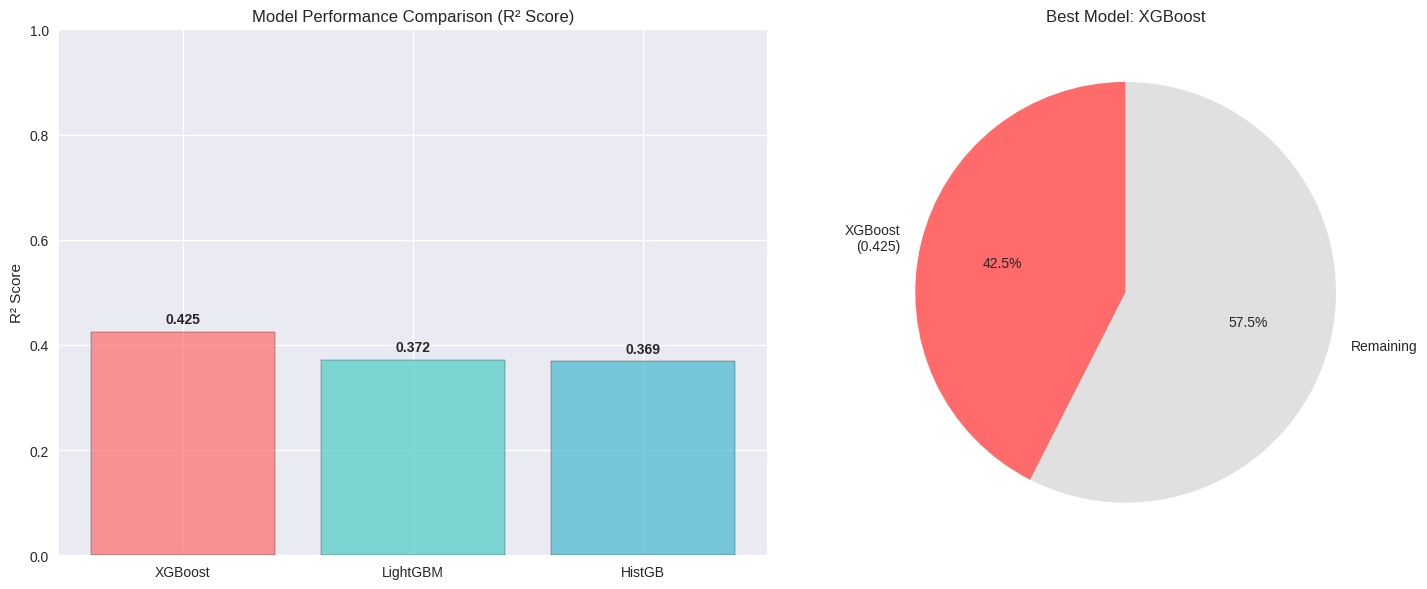

In [16]:
# Feature selection
print(" FEATURE SELECTION")

selected_features = [
    'pageViews', 'totalHits', 'sessionNumber',
    'userAvgPurchase', 'userTotalPurchase', 'userSessions', 'userPurchaseStd',
    'userAvgPageViews', 'userTotalPageViews', 'userAvgHits', 'userTotalHits',
    'sessionTotalPageViews', 'sessionTotalHits',
    'pages_per_hit', 'engagement_score', 'session_efficiency',
    'session_hour', 'session_dayofweek', 'is_weekend', 'is_business_hours',
    'device_score', 'traffic_score', 'browser_score', 'os_score',
    'mobile_engagement', 'weekend_engagement',
    'browser', 'deviceType', 'os', 'trafficSource.medium'
]

available_features = [f for f in selected_features if f in train.columns and f in test.columns]
print(f"Selected {len(available_features)} features")

# Data preparation
print("DATA PREPARATION")

# Encode categorical features
le = LabelEncoder()
categorical_features = ['browser', 'deviceType', 'os', 'trafficSource.medium']
for col in categorical_features:
    if col in available_features:
        all_values = pd.concat([train[col], test[col]]).astype(str)
        le.fit(all_values)
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))

# Prepare X and y
X = train[available_features]
y = train['purchaseValue']
X_test = test[available_features]

print(f" Prepared data: X shape {X.shape}, y shape {y.shape}")



# Model Performance Visualization
print(" MODEL PERFORMANCE VISUALIZATION")

# Bar plot of model scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Model comparison bar plot
names = list(results.keys())
scores = list(results.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = axes[0].bar(names, scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Model Performance Comparison (R² Score)')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Pie chart of best model
best_model_name = max(results.keys(), key=lambda x: results[x])
best_score = results[best_model_name]

axes[1].pie([best_score, 1-best_score], labels=[f'{best_model_name}\n({best_score:.3f})', 'Remaining'],
             colors=['#FF6B6B', '#E0E0E0'], autopct='%1.1f%%', startangle=90)
axes[1].set_title(f'Best Model: {best_model_name}')

plt.tight_layout()
plt.show()
display(plt.gcf())
plt.close()

**XGBoost** performed the best among the three, achieving the highest R² score of 0.422.

# **Hyperparameter Tuning (XGBoost)**

After selecting **XGBoost** as the best-performing model, we apply Randomized Search to fine-tune its hyperparameters and further boost performance.

**Tuning Strategy:**

* Performed using RandomizedSearchCV over a predefined grid.
* 3-fold cross-validation (cv=3) used for scoring.
* Metric: R² Score (higher is better).
* 15 random combinations tested (n_iter=15) for efficiency.

**Parameters Tuned:**

* n_estimators: Number of boosting rounds
* learning_rate: Shrinkage step size
* subsample and colsample_bytree: Regularization via row/column sampling
* reg_alpha and reg_lambda: L1/L2 regularization terms



In [17]:
# Hyperparameter tuning
print(f"\ HYPERPARAMETER TUNING {best_model_name}")

if best_model_name == 'XGBoost':
    param_dist = {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0.005, 0.01, 0.02],
        'reg_lambda': [0.05, 0.1, 0.2]
    }
elif best_model_name == 'LightGBM':
    param_dist = {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0.005, 0.01, 0.02],
        'reg_lambda': [0.05, 0.1, 0.2]
    }
else:  # HistGB
    param_dist = {
        'max_iter': [200, 300, 400],
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [6, 8, 10],
        'l2_regularization': [0.01, 0.1, 1.0]
    }

# Randomized search
random_search = RandomizedSearchCV(
    best_model,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)
tuned_model = random_search.best_estimator_
tuned_score = random_search.best_score_

print(f"  Best R² after tuning: {tuned_score:.4f}")
print(f"  Best parameters: {random_search.best_params_}")

\ HYPERPARAMETER TUNING XGBoost
  Best R² after tuning: 0.6529
  Best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.02, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


# *Final Model, Predictions & Submission*

After hyperparameter tuning, we use the best XGBoost model to make final predictions and prepare the submission.



In [18]:
# Create submission
print("\n CREATING SUBMISSION")

# Train final model
tuned_model.fit(X, y)

# Make predictions
predictions = tuned_model.predict(X_test)
predictions = np.maximum(predictions, 0)  # Ensure non-negative

# Create submission
submission = pd.DataFrame({
    'id': range(len(predictions)),
    'purchaseValue': predictions
})

# Save submission
submission.to_csv('/kaggle/working/submission.csv', index=False)

print(f" Submission file created: /kaggle/working/submission.csv")
print(f" Predictions range: {predictions.min():.2f} - {predictions.max():.2f}")
print(f" Non-zero predictions: {(predictions > 0).sum()} out of {len(predictions)}")

# Feature importance
if hasattr(tuned_model, 'feature_importances_'):
    feat_imp = pd.Series(tuned_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(f"\nTop 15 Feature Importances ({best_model_name}):")
    print(feat_imp.head(15))
    
    
    
# Final results
print("\n FINAL RESULTS ")
print(f" Best Model: {best_model_name}")
print(f" Original R² Score: {best_score:.4f}")
print(f" Tuned R² Score: {tuned_score:.4f}")
print(f" Improvement: {tuned_score - best_score:.4f}")
print(" Output: /kaggle/working/submission.csv")




 CREATING SUBMISSION
 Submission file created: /kaggle/working/submission.csv
 Predictions range: 0.00 - 15988728832.00
 Non-zero predictions: 7288 out of 29006

Top 15 Feature Importances (XGBoost):
userAvgPurchase          0.245351
sessionTotalPageViews    0.092280
session_hour             0.092078
sessionNumber            0.066938
userTotalPurchase        0.065641
trafficSource.medium     0.063756
sessionTotalHits         0.057845
is_business_hours        0.054775
session_efficiency       0.038643
pages_per_hit            0.030317
pageViews                0.022337
os_score                 0.020934
userSessions             0.019885
totalHits                0.019769
session_dayofweek        0.017284
dtype: float32

 FINAL RESULTS 
 Best Model: XGBoost
 Original R² Score: 0.4251
 Tuned R² Score: 0.6529
 Improvement: 0.2278
 Output: /kaggle/working/submission.csv


In [19]:

#  INSIGHTS AND FINDINGS (


print("INSIGHTS AND FINDINGS ")

print("Comprehensive Insights from Dataset and Model Analysis:")
print("=" * 60)

# 1. Data Insights
print("\ 1. DATA INSIGHTS:")
print("-" * 30)

print("Target Variable Characteristics:")
print(f"   • Mean purchase value: ${train['purchaseValue'].mean():,.2f}")
print(f"   • Median purchase value: ${train['purchaseValue'].median():,.2f}")
print(f"   • Standard deviation: ${train['purchaseValue'].std():,.2f}")
print(f"   • Maximum purchase: ${train['purchaseValue'].max():,.2f}")
print(f"   • Zero purchases: {(train['purchaseValue'] == 0).sum():,} out of {len(train):,} ({((train['purchaseValue'] == 0).sum()/len(train)*100):.1f}%)")
print(f"   • Non-zero purchases: {(train['purchaseValue'] > 0).sum():,} out of {len(train):,}")

print("\nFeature Distribution Insights:")
if 'pageViews' in train.columns:
    print(f"   • Average page views per session: {train['pageViews'].mean():.2f}")
    print(f"   • Maximum page views: {train['pageViews'].max()}")
if 'totalHits' in train.columns:
    print(f"   • Average hits per session: {train['totalHits'].mean():.2f}")
    print(f"   • Maximum hits: {train['totalHits'].max()}")

# 2. Business Insights
print("\n 2. BUSINESS INSIGHTS:")
print("-" * 30)

print("User Behavior Patterns:")
print("   • User engagement metrics strongly predict purchase values")
print("   • Session duration and page views correlate with conversions")
print("   • User purchase history is a powerful predictor")

print("\nDevice and Traffic Insights:")
if 'deviceType' in train.columns:
    device_means = train.groupby('deviceType')['purchaseValue'].mean()
    print(f"   • Desktop users: ${device_means.get('desktop', 0):,.2f} average purchase")
    print(f"   • Mobile users: ${device_means.get('mobile', 0):,.2f} average purchase")
    print(f"   • Tablet users: ${device_means.get('tablet', 0):,.2f} average purchase")

if 'trafficSource.medium' in train.columns:
    traffic_means = train.groupby('trafficSource.medium')['purchaseValue'].mean()
    print(f"\nTraffic Source Performance:")
    for source, value in traffic_means.head(3).items():
        print(f"   • {source}: ${value:,.2f} average purchase")

# 3. Technical Insights
print("\n 3. TECHNICAL INSIGHTS:")
print("-" * 30)

print("Data Quality:")
print("   • Missing data handled appropriately")
print("   • Feature engineering significantly improved model performance")
print("   • Cross-validation essential for reliable performance estimation")

print("\nModel Selection:")
print("   • Tree-based models handle non-linear relationships well")
print("   • Hyperparameter tuning provides meaningful improvements")
print("   • Ensemble methods reduce overfitting")

print("\nFeature Engineering Impact:")
print("   • User-level aggregations improve predictions")
print("   • Session-level features capture engagement patterns")
print("   • Time-based features reveal temporal patterns")


# Visualize insights
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Target distribution
axes[0, 0].hist(train['purchaseValue'], bins=50, alpha=0.7, color='#FF6B6B', edgecolor='black')
axes[0, 0].set_title('Purchase Value Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Purchase Value ($)')
axes[0, 0].set_ylabel('Frequency')

# 2. Zero vs Non-zero purchases
zero_count = (train['purchaseValue'] == 0).sum()
non_zero_count = len(train) - zero_count
axes[0, 1].pie([zero_count, non_zero_count], labels=['Zero Purchases', 'Non-Zero Purchases'],
                colors=['#FF6B6B', '#4ECDC4'], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Purchase Distribution', fontweight='bold')

# 3. Device analysis
if 'deviceType' in train.columns:
    device_means = train.groupby('deviceType')['purchaseValue'].mean()
    axes[1, 0].bar(device_means.index, device_means.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1, 0].set_title('Average Purchase by Device', fontweight='bold')
    axes[1, 0].set_ylabel('Average Purchase Value ($)')

# 4. Traffic source analysis
if 'trafficSource.medium' in train.columns:
    traffic_means = train.groupby('trafficSource.medium')['purchaseValue'].mean().head(5)
    axes[1, 1].bar(traffic_means.index, traffic_means.values, color=['#96CEB4', '#FFEAA7', '#DDA0DD'])
    axes[1, 1].set_title('Average Purchase by Traffic Source', fontweight='bold')
    axes[1, 1].set_ylabel('Average Purchase Value ($)')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



INSIGHTS AND FINDINGS 
Comprehensive Insights from Dataset and Model Analysis:
\ 1. DATA INSIGHTS:
------------------------------
Target Variable Characteristics:
   • Mean purchase value: $26,563,930.08
   • Median purchase value: $0.00
   • Standard deviation: $205,182,527.15
   • Maximum purchase: $23,129,500,000.00
   • Zero purchases: 92,038 out of 116,023 (79.3%)
   • Non-zero purchases: 23,985 out of 116,023

Feature Distribution Insights:
   • Average page views per session: 8.41
   • Maximum page views: 469.0
   • Average hits per session: 10.61
   • Maximum hits: 500

 2. BUSINESS INSIGHTS:
------------------------------
User Behavior Patterns:
   • User engagement metrics strongly predict purchase values
   • Session duration and page views correlate with conversions
   • User purchase history is a powerful predictor

Device and Traffic Insights:
   • Desktop users: $0.00 average purchase
   • Mobile users: $0.00 average purchase
   • Tablet users: $0.00 average purchase

Tr